# Multiomics analysis with `muon` - Vertical integration

In this notebook we will perform exploratory analysis and joint dimensionality reduction on unmatched scRNA-seq and scATAC-seq data of differentiating glutamatergic neurons from [Trevino et al.2020](https://www.biorxiv.org/content/10.1101/2020.12.29.424636v2.full). The original datasets can be downloaded following the instructions in https://github.com/GreenleafLab/brainchromatin. The data was cleaned and converted to `anndata` objects in the script `prep_data.Rmd`.

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [2]:
import muon as mu

In [3]:
## Plotting utils
import matplotlib.pyplot as plt
import matplotlib

## Load single-view data

The data for each omic view is stored in [`AnnData`](https://anndata.readthedocs.io/en/latest/index.html) format. An `AnnData` object allows us to store a matrix and add annotations to its different dimensions, defined as “observations” (i.e. cells), and measured “variables” (i.e. genes for the RNA view and peaks for the ATAC modalities).

In [75]:
rna_adata = sc.read_h5ad('/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/scRNA_clean_SCE.h5ad')
atac_adata = sc.read_h5ad('/home/jovyan/mount/gdrive/sc-multiomics-course-2021/processed_data/scATAC_clean_SCE.h5ad')

In [ ]:
# rna_adata = sc.read_h5ad('./processed_data/scRNA.h5ad')
# atac_adata = sc.read_h5ad('./processed_data/scATAC_clean_SCE.h5ad')

We can access the annotations on cells using `adata.obs`

In [76]:
rna_adata.obs

,Sample.ID,Age,Tissue.ID,Sample.Type,Batch,seurat_clusters,RNA.Counts,RNA.Features,Percent.MT,Percent.Ribo,Cell.Barcode,cluster_name,in_GluN_trajectory
hft_w16_p7_r1_AAACCCAAGTATTGCC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c8,5748,2339,0.029749,0.202853,AAACCCAAGTATTGCC,Cyc. Prog.,False
hft_w16_p7_r1_AAACCCAAGTTCACTG,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,10640,3408,0.037027,0.183723,AAACCCAAGTTCACTG,GluN3,True
hft_w16_p7_r1_AAACCCACAAGAGTGC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,6734,2729,0.031329,0.133036,AAACCCACAAGAGTGC,GluN3,True
hft_w16_p7_r1_AAACCCACAAGATTGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,5186,2393,0.104644,0.066294,AAACCCACAAGATTGA,GluN7,True
hft_w16_p7_r1_AAACCCACAGATGCGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c2,4689,2013,0.051386,0.178678,AAACCCACAGATGCGA,GluN1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r2_TTTGTTGCAGCACCCA,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c6,8532,3497,0.018749,0.136396,TTTGTTGCAGCACCCA,Early RG,False
hft_w16_p7_r2_TTTGTTGCAGGCTACC,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c2,6689,2393,0.045577,0.246862,TTTGTTGCAGGCTACC,GluN1,True
hft_w16_p7_r2_TTTGTTGGTCGCTTAA,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c2,3865,1799,0.035954,0.159079,TTTGTTGGTCGCTTAA,GluN1,True
hft_w16_p7_r2_TTTGTTGGTCGTACAT,hft_w16_p7_r2,pcw16,HFT7,HFT,b2020_03,c2,5293,2365,0.032861,0.158074,TTTGTTGGTCGTACAT,GluN1,True


In [77]:
atac_adata.obs

,Sample.ID,Age,Tissue.ID,Sample.Type,Batch,Iterative.LSI.Clusters,Tss.Enrichment,Cell.Barcode,TSS.Enrichment.Unsmoothed,clusterID,cluster_name,cluster_name_long,Assay,in_GluN_trajectory
hft_w16_p7_r1_cell_1,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c11,19.157088,AAACGAAGTTTGTGAC-1,29.118774,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r1_cell_2,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,24.651890,AAACGAATCCCAATGA-1,39.130435,c7,GluN3,Glutamatergic Neuron 3,scATAC,True
hft_w16_p7_r1_cell_3,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,5.215686,AAACGAATCGTGGGTC-1,14.000000,c7,GluN3,Glutamatergic Neuron 3,scATAC,True
hft_w16_p7_r1_cell_5,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c6,29.726230,AAACGAATCTTGTCGC-1,43.396226,c6,GluN2,Glutamatergic Neuron 2,scATAC,True
hft_w16_p7_r1_cell_7,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c6,25.531414,AAACTCGAGGCTAAAT-1,43.243243,c6,GluN2,Glutamatergic Neuron 2,scATAC,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r3_cell_2860,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c8,20.657277,TTTGGTTGTGTCGTCG-1,36.056338,c8,nIPC,neuronal Intermedate Progenitor Cell,scATAC,True
hft_w16_p7_r3_cell_2862,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,15.333333,TTTGTGTAGGTTGTGG-1,32.000000,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2863,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,22.873213,TTTGTGTGTACTTCGA-1,46.215139,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2864,hft_w16_p7_r3,pcw16,HFT7,HFT,b2020_03,c11,18.983297,TTTGTGTGTTCGGGAA-1,28.888889,c11,Early RG,Early Radial Glia,scATAC,False


We can access the annotation on features with `adata.var`. In the ATAC object `atac_adata.var` also stores the genomic coordinates of the peaks. 

In [80]:
rna_adata.var

,gene_name
ENSG00000243485,MIR1302-2
ENSG00000237613,FAM138A
ENSG00000186092,OR4F5
ENSG00000238009,RP11-34P13.7
ENSG00000239945,RP11-34P13.8
...,...
ENSG00000212907,MT-ND4L
ENSG00000198886,MT-ND4
ENSG00000198786,MT-ND5
ENSG00000198695,MT-ND6


In [81]:
atac_adata.var

,seqnames,start,end,width,strand,name,classification
c2_peak_1,chr1,10028,10528,501,*,c2_peak_1,distal
c4_peak_1,chr1,180647,181147,501,*,c4_peak_1,distal
c6_peak_2,chr1,181234,181734,501,*,c6_peak_2,distal
c9_peak_2a,chr1,191218,191718,501,*,c9_peak_2a,distal
c1_peak_1,chr1,265926,266426,501,*,c1_peak_1,distal
...,...,...,...,...,...,...,...
c11_peak_130741,chr22,50775058,50775558,501,*,c11_peak_130741,genic
c12_peak_153317b,chr22,50783369,50783869,501,*,c12_peak_153317b,proximal
c7_peak_124670,chr22,50783886,50784386,501,*,c7_peak_124670,proximal
c12_peak_153318,chr22,50785216,50785716,501,*,c12_peak_153318,distal


## Build `MuData` object

`muon` is a framework for multimodal data analysis with a strong focus on multi-omics.

`muon.MuData` is a multi-modal data container, that comprises a dictionary with `AnnData` objects, one per modality, in its `.mod` attribute. Just as `AnnData` objects themselves, they also contain attributes like `.obs` with annotation of observations (samples or cells), `.obsm` with their multidimensional annotations such as embeddings, etc.


In [82]:
mdata = mu.MuData({'rna': rna_adata, 'atac': atac_adata})

In [83]:
mdata

MuData object with n_obs × n_vars = 25796 × 691127
  2 modalities
    rna:	19373 x 33197
      obs:	'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory'
      var:	'gene_name'
    atac:	6423 x 657930
      obs:	'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'Iterative.LSI.Clusters', 'Tss.Enrichment', 'Cell.Barcode', 'TSS.Enrichment.Unsmoothed', 'clusterID', 'cluster_name', 'cluster_name_long', 'Assay', 'in_GluN_trajectory'
      var:	'seqnames', 'start', 'end', 'width', 'strand', 'name', 'classification'

You can see the object now concatenates `.obs` from both assays in a single object, and the info about the original assay for each column is saved

In [84]:
mdata.obs

,rna:Sample.ID,rna:Age,rna:Tissue.ID,rna:Sample.Type,rna:Batch,rna:seurat_clusters,rna:RNA.Counts,rna:RNA.Features,rna:Percent.MT,rna:Percent.Ribo,...,atac:Batch,atac:Iterative.LSI.Clusters,atac:Tss.Enrichment,atac:Cell.Barcode,atac:TSS.Enrichment.Unsmoothed,atac:clusterID,atac:cluster_name,atac:cluster_name_long,atac:Assay,atac:in_GluN_trajectory
hft_w16_p7_r1_AAACCCAAGTATTGCC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c8,5748.0,2339.0,0.029749,0.202853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCAAGTTCACTG,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,10640.0,3408.0,0.037027,0.183723,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCACAAGAGTGC,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c5,6734.0,2729.0,0.031329,0.133036,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCACAAGATTGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c7,5186.0,2393.0,0.104644,0.066294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hft_w16_p7_r1_AAACCCACAGATGCGA,hft_w16_p7_r1,pcw16,HFT7,HFT,b2020_03,c2,4689.0,2013.0,0.051386,0.178678,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hft_w16_p7_r3_cell_2860,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c8,20.657277,TTTGGTTGTGTCGTCG-1,36.056338,c8,nIPC,neuronal Intermedate Progenitor Cell,scATAC,True
hft_w16_p7_r3_cell_2862,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c11,15.333333,TTTGTGTAGGTTGTGG-1,32.000000,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2863,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c11,22.873213,TTTGTGTGTACTTCGA-1,46.215139,c11,Early RG,Early Radial Glia,scATAC,False
hft_w16_p7_r3_cell_2864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,b2020_03,c11,18.983297,TTTGTGTGTTCGGGAA-1,28.888889,c11,Early RG,Early Radial Glia,scATAC,False


Observations and variables of the `MuData` object are global, which means that observations with the identical name (`.obs_names`) in different modalities are considered to be the same observation. This also means variable names (`.var_names`) should be unique.

Notably, individual modalities inside the MuData container are stored as references to the original objects and are full-fledged AnnData objects, which can be operated independently with any tool that works on AnnData objects. So if we change the single-omic `AnnData` objects, the changes will be reflected in the container.

For example, if we add a column to the `.obs` of the RNA modality object, we can see the new column is also accessible from the container.


In [85]:
rna_adata.obs["new_col"] = 0
mdata["rna"]

AnnData object with n_obs × n_vars = 19373 × 33197
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory', 'new_col'
    var: 'gene_name'

However, the column is not found in the common `.obs`

In [86]:
"rna:new_col" in mdata.obs.columns

False

To update the common obs, we can use the `.update_obs()` method, that syncs up the data.

In [87]:
mdata.update_obs()
mdata.obs["rna:new_col"]

hft_w16_p7_r1_AAACCCAAGTATTGCC    0.0
hft_w16_p7_r1_AAACCCAAGTTCACTG    0.0
hft_w16_p7_r1_AAACCCACAAGAGTGC    0.0
hft_w16_p7_r1_AAACCCACAAGATTGA    0.0
hft_w16_p7_r1_AAACCCACAGATGCGA    0.0
                                 ... 
hft_w16_p7_r3_cell_2860           NaN
hft_w16_p7_r3_cell_2862           NaN
hft_w16_p7_r3_cell_2863           NaN
hft_w16_p7_r3_cell_2864           NaN
hft_w16_p7_r3_cell_2865           NaN
Name: rna:new_col, Length: 25796, dtype: float64

To update everything we can use `mdata.update()`

## Preprocessing RNA modality

For preprocessing the scRNA data we can use the standard functions implemented in `scanpy`. In this case cells have already been filtered by percentage of mitochrondrial counts and total counts.

In [89]:
sc.pp.normalize_total(rna_adata, target_sum=1e4)
sc.pp.log1p(rna_adata)

We identify highly variable genes for dimensionality reduction

In [90]:
sc.pp.highly_variable_genes(rna_adata,min_mean=0.0125, max_mean=3, min_disp=0.5)

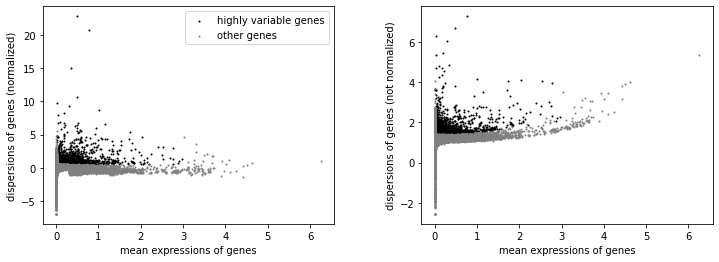

In [91]:
sc.pl.highly_variable_genes(rna_adata)

Let's check how many genes are identified as highly variable

In [92]:
np.sum(rna_adata.var.highly_variable)

2629

Next we run dimensionality reduction with PCA and use PCs to construct a K-nearest neighbor graph for visualization of our cells in UMAP

In [93]:
sc.pp.pca(rna_adata)
sc.pp.neighbors(rna_adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(rna_adata)

In [94]:
rna_adata

AnnData object with n_obs × n_vars = 19373 × 33197
    obs: 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'cluster_name', 'in_GluN_trajectory', 'new_col'
    var: 'gene_name', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

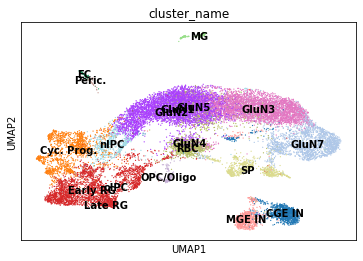

In [121]:
sc.pl.umap(rna_adata, color=["cluster_name"], legend_loc="on data")

We can see differences in expression of known marker genes for neuronal intermediate progenitor cells (nIPC) and glutamatergic excitatory neurons (GluN)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/anndata/_core/anndata.py:891: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['MIR1302-2', 'FAM138A', 'OR4F5', 'RP11-34P13.7', 'RP11-34P13.8']

    Inferred to be: categorical

  names = self._prep_dim_index(names, "var")


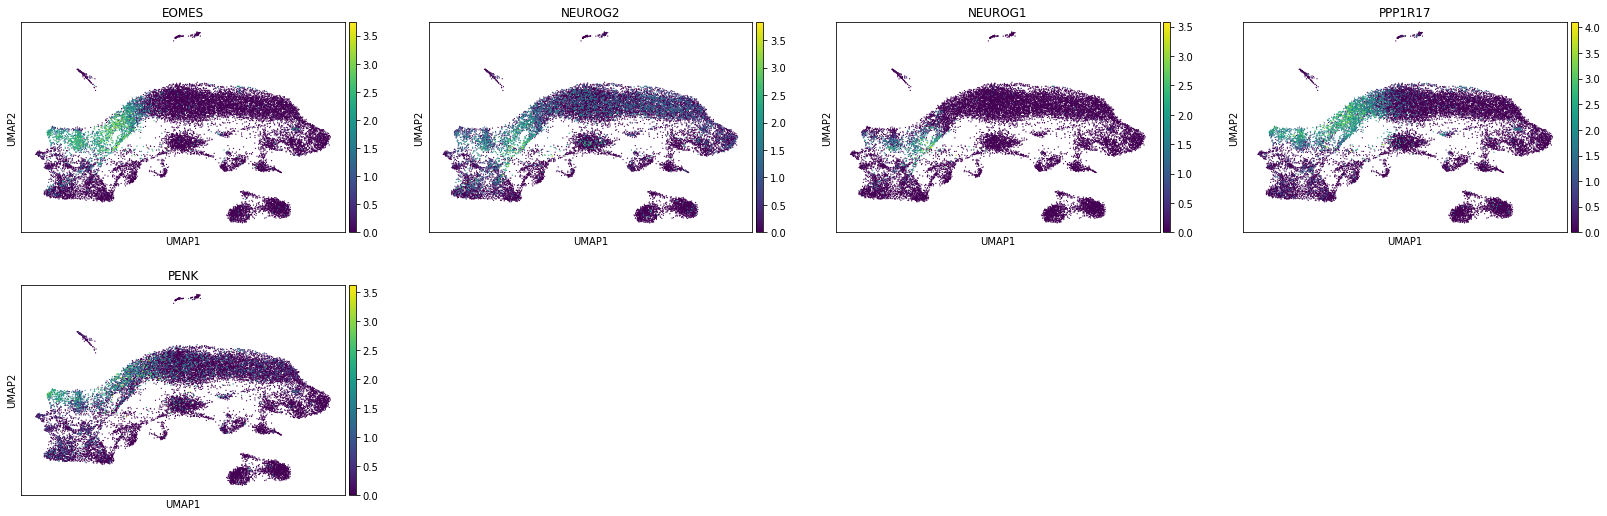

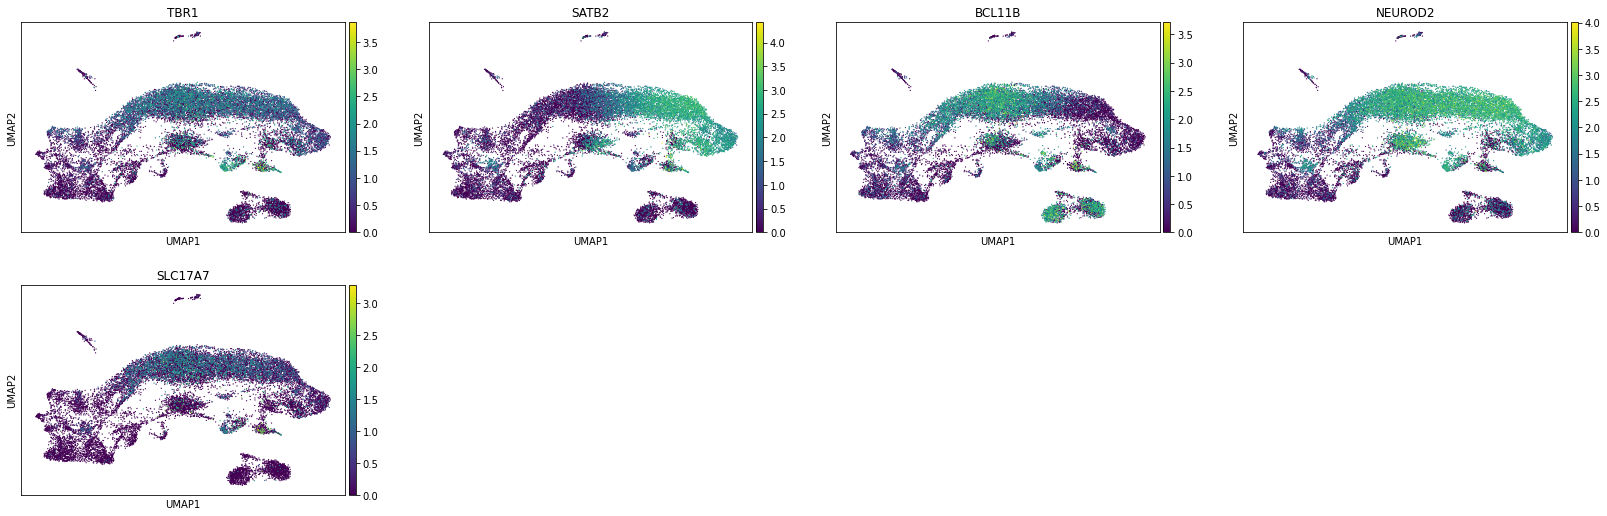

In [99]:
marker_genes = {
    "nIPC":['EOMES', 'PPP1R17', 'PENK', 'NEUROG1', 'NEUROG2'],
    "GluN":['NEUROD2', 'TBR1', 'BCL11B', 'SATB2', 'SLC17A7']
               }

rna_adata.var_names = rna_adata.var["gene_name"].values.copy()
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["nIPC"])])
sc.pl.umap(rna_adata, color=rna_adata.var_names[rna_adata.var_names.isin(marker_genes["GluN"])])

We can use ordinary diffusion pseudotime to order excitatory neurons along a differentiation trajectory stemming from the nIPCs. 

In [104]:
## Subset to glutamatergic neurons
ext_rna_adata = rna_adata[rna_adata.obs["in_GluN_trajectory"]].copy()
sc.pp.pca(ext_rna_adata)
sc.pp.neighbors(ext_rna_adata, n_neighbors=10, n_pcs=30)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


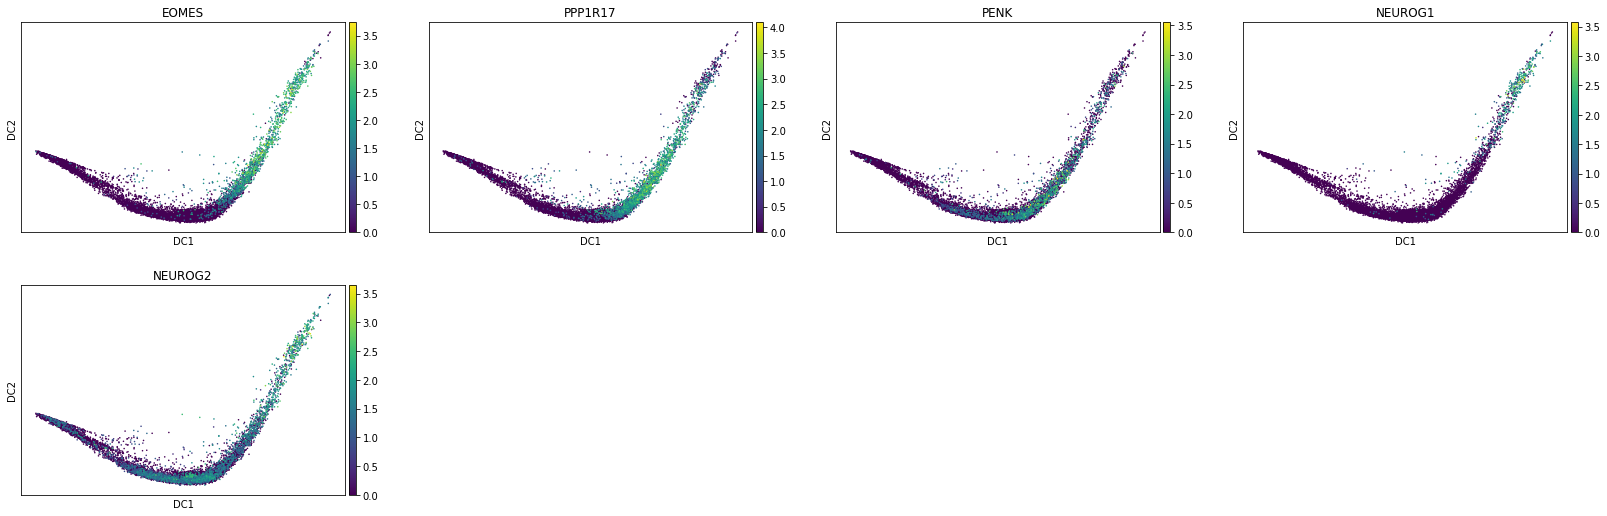

In [105]:
sc.tl.diffmap(ext_rna_adata)
sc.pl.diffmap(ext_rna_adata, color=marker_genes['nIPC'])

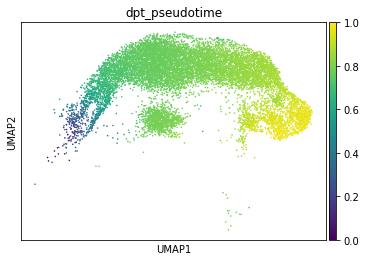

In [106]:
## Define the putative root cell (start of differentiation trajectory)
## we take the maximum for DC1 as the root nIPC
ext_rna_adata.uns['iroot'] = ext_rna_adata.obsm["X_diffmap"][:,1].argmax() 
sc.tl.dpt(ext_rna_adata)
sc.pl.umap(ext_rna_adata, color=["dpt_pseudotime"])

We can already observe different patterns of expression along pseudotime for the GluN marker genes

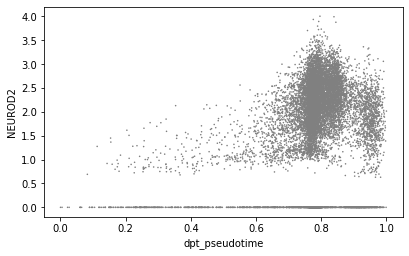

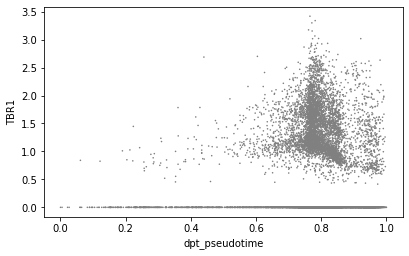

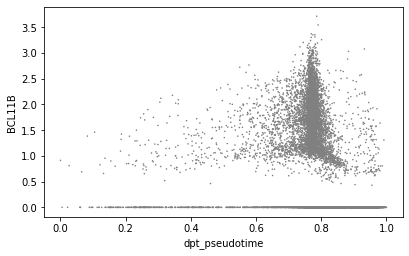

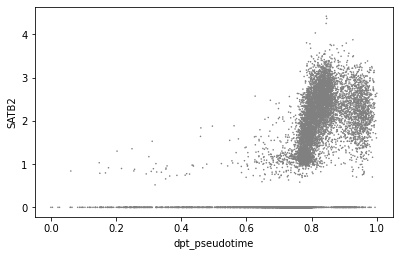

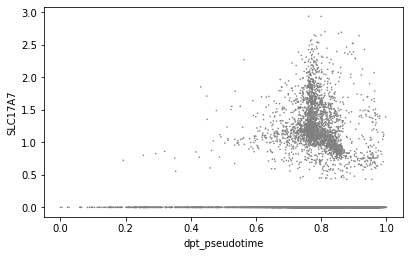

In [107]:
for g in marker_genes["GluN"]:
    sc.pl.scatter(ext_rna_adata, 'dpt_pseudotime', g)

---

## Preprocessing ATAC modality

We are going to use the functions for preprocessing of scATAC data in python implemented in `muon`

In [108]:
from muon import atac as ac

Again, here QC metrics such as the signal at Transcriptional Start Sites and cell and gene filtering was already performed. Let's recalculate QC metric just to check the distribution of certain metrics

In [109]:
sc.pp.calculate_qc_metrics(atac_adata, percent_top=None, log1p=False, inplace=True)

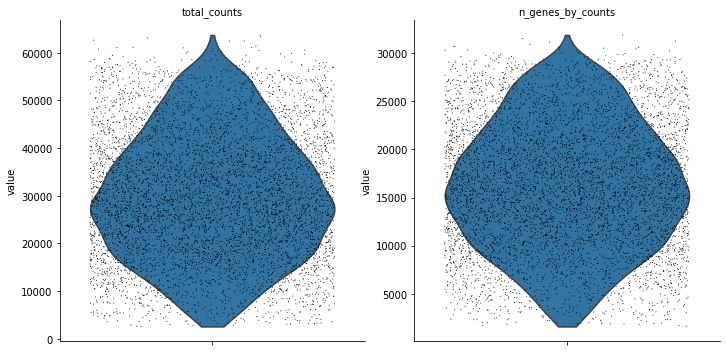

In [110]:
sc.pl.violin(atac_adata, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

We now binarize the count matrix: since scATAC data is extremely sparse and most non-zero values in it are 1 and 2.

In [111]:
ac.pp.binarize(atac_adata)

Then we normalize the data using TF-IDF (Term Frequency - Inverse Document Frequency). This is a normalization technique adapted from text processing, in this case we consider each peak as a "term" and each cell as a "document". This is typically followed by singular value decomposition (SVD) — the same technique that convential principal component analysis (PCA) uses — to generate latent components, and these two steps together are referred to as latent semantic indexing (LSI).

In [112]:
ac.pp.tfidf(atac_adata, scale_factor=1e4)

/home/jovyan/my-conda-envs/sc2021-multiomics/lib/python3.9/site-packages/muon/_atac/preproc.py:64: RuntimeWarning: divide by zero encountered in true_divide
  idf = np.asarray(adata.shape[0] / adata.X.sum(axis=0)).reshape(-1)


In [113]:
## For the PCA step, we can use the standard scanpy function or ac.pp.lsi
sc.pp.pca(atac_adata)

A word of caution on LSI: typically we see that the first latent factor or the first few latent factors found with this procedure are very strongly correlated with the total counts in the cells. Some workflows suggest excluding these latent factors that simply capture the coverage. In practice, it's not straight-forward to decide which latent factors whould be kept and which should be excluded, so for now we keep them all.

In [114]:
atac_adata.obsm["X_lsi"] = atac_adata.obsm["X_pca"].copy()
atac_adata.obs["LSI_f1"] = atac_adata.obsm["X_lsi"][:,0]
atac_adata.obs["LSI_f2"] = atac_adata.obsm["X_lsi"][:,1]

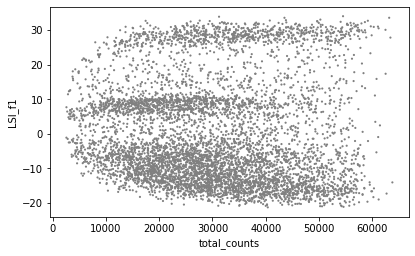

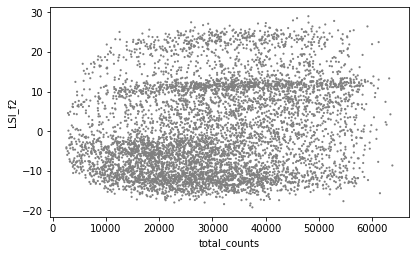

In [115]:
sc.pl.scatter(atac_adata, "total_counts", "LSI_f1")
sc.pl.scatter(atac_adata, "total_counts", "LSI_f2")

We can now compute a KNN graph for clustering and UMAP

In [116]:
sc.pp.neighbors(atac_adata, use_rep="X_lsi", n_neighbors=10, n_pcs=30)
sc.tl.umap(atac_adata)

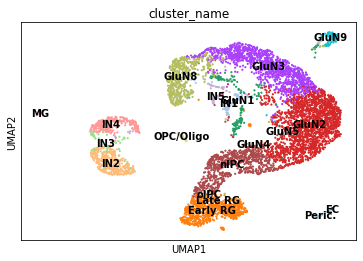

In [120]:
sc.pl.umap(atac_adata, color=["cluster_name"], legend_loc="on data")

---

## Multi-modal analysis

Now it's time to start the joint analysis of scRNA and scATAC, where we aim to identify non-coding chromatin regions associated with expression of variable genes during excitatory neuron development.

Firstly, let's save the progress we've done on the single-modalities in the `.obs` of the multi-omic object container

In [86]:
mdata.update_obs()

## Co-embedding 

In [ ]:
# ...

---

## Aggregating expression and accessibility profiles 

We suggest creating pseudobulk profiles of neighbouring cells in the KNN graph. As well as denoising, this step reduces the dimensionality of our dataset (on the cell axis), speeding up computations.

In [118]:
# ...

---

## Associating gene expression to accessibility

We first want to find genes that have variable expression in pseudotime. We will restrict the search to peaks associated to these variable genes.

We take a naive approach, correlating log-counts in expression to the value of pseudotime in the joint embedding. For better approaches to find variable genes in pseudotime, see (A) cellrank, (B) tradeSeq and (C) ...

In [119]:
# ...